# EMIT Surface Reflectance for one pixel

Brent Wilder


20 September 2024


In [1]:
import earthaccess
import xarray as xr
import requests
import io
from emit_tools import emit_xarray,get_image_selector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Log in to earthaccess
earthaccess.login(persist=True)

### Type in Latitude and Longitude of interest here

In [3]:
lat, lon = 36.0103951551935, 75.63717366720297

### Next, there will be a drop down menu to select the time you want

In [5]:
# run to get drop down menu
get_image_selector(lat, lon)

Dropdown(description='Select Date:', options=(('2023-03-29T09:03:21.000Z', {'start_datetime': '2023-03-29T09:0…

Available URLs for 2024-03-30T07:47:57.000Z:
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240330T074757_2409005_010/EMIT_L2A_RFL_001_20240330T074757_2409005_010.nc
Available URLs for 2024-05-21T11:06:24.000Z:
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240521T110624_2414208_020/EMIT_L2A_RFL_001_20240521T110624_2414208_020.nc


### Copy and paste the link HTTPS link above down below to the URL

In [10]:
# choose which one you would like
url = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240521T110624_2414208_020/EMIT_L2A_RFL_001_20240521T110624_2414208_020.nc'

### Now run the below chunk to have the EMIT data in memory (it will not save it to your computer)

In [11]:
# Download the dataset from the HTTPS URL
response = requests.get(url)
response.raise_for_status()

# Read the data into an xarray dataset
data = io.BytesIO(response.content)
ds = emit_xarray(data,ortho=True)
ds

Handling BytesIO input...


<xarray.Dataset>
Dimensions:           (latitude: 1881, longitude: 2381, bands: 285)
Coordinates:
  * latitude          (latitude) float64 36.18 36.17 36.17 ... 35.16 35.16 35.16
  * longitude         (longitude) float64 75.29 75.29 75.29 ... 76.58 76.58
    fwhm              (bands) float32 8.415 8.415 8.415 ... 8.806 8.807 8.809
    good_wavelengths  (bands) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    wavelengths       (bands) float32 381.0 388.4 395.8 ... 2.486e+03 2.493e+03
    elev              (latitude, longitude) float32 -9.999e+03 ... -9.999e+03
    spatial_ref       int64 0
Dimensions without coordinates: bands
Data variables:
    reflectance       (latitude, longitude, bands) float32 -9.999e+03 ... -9....
Attributes: (12/40)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [ 7.52859981e+01  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...
    granule_id:                        dummy_id
    Orthorectified:                    True

### Now run below to visualize and select spectra

In [62]:
# You can change your lat,lon now too if you'd like
lat,lon = 35.89, 75.85

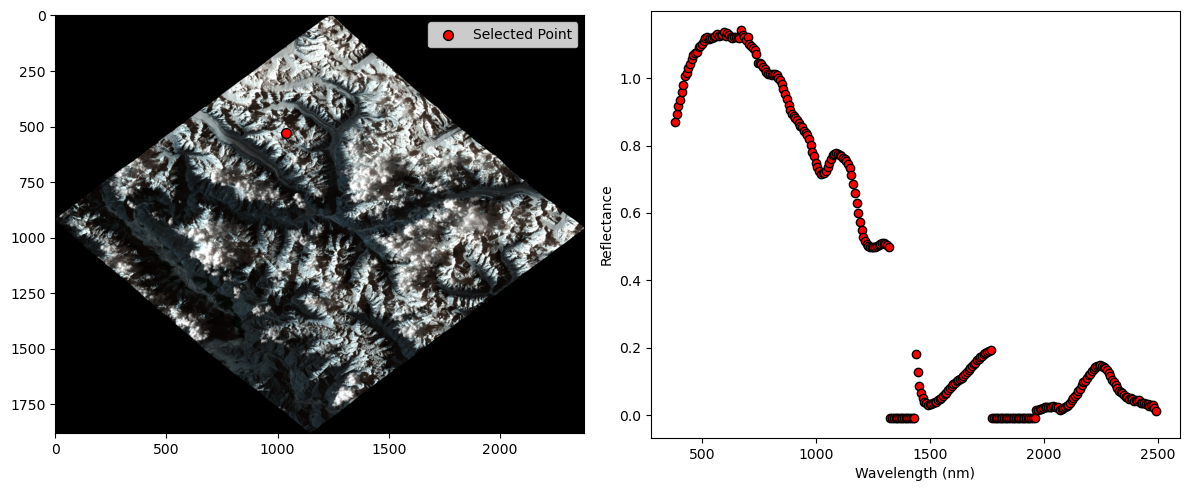

In [63]:
# Select the nearest pixel based on latitude and longitude
spectra = ds.sel(longitude=lon, latitude=lat, method='nearest')

# Extract reflectance data
reflectance_data = ds['reflectance']

# Select bands close to RGB
rgb_image = reflectance_data.isel(bands=[11, 23, 34])

# Normalize the RGB image for display
rgb_image = np.clip(rgb_image / np.nanmax(rgb_image*0.5), 0, 1)

# Convert lat/lon coordinates to pixel indices
lat_idx = np.abs(ds.latitude.values - lat).argmin()
lon_idx = np.abs(ds.longitude.values - lon).argmin()

# Set up the figure and axes for side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(rgb_image)
ax1.scatter(lon_idx, lat_idx, color='red', marker='o', s=50, edgecolor='k', label='Selected Point')
ax1.legend()
wavelengths = ds['wavelengths'].values
reflectance_at_pixel = reflectance_data[lat_idx, lon_idx, :].values
ax2.scatter(wavelengths, reflectance_at_pixel, c='red', edgecolor='k')
ax2.set_xlabel('Wavelength (nm)')
ax2.set_ylabel('Reflectance')
plt.tight_layout()
plt.show()


In [64]:
#save to pandas and csv
df = pd.DataFrame(data = wavelengths.flatten(), columns=['wavelengths'])
df['reflectance'] = reflectance_at_pixel.flatten()
df

,wavelengths,reflectance
0,381.005585,0.869589
1,388.409210,0.894772
2,395.815826,0.918073
3,403.225403,0.935188
4,410.638000,0.958018
...,...,...
280,2463.381592,0.025956
281,2470.767822,0.029042
282,2478.153076,0.028506
283,2485.538574,0.019988


In [65]:
id = url.split('/')[-1].replace('.nc', '')
df.to_csv(f'./data/{id}_{lat}_{lon}.csv', index=False)